## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.05]
redice_lr_patient = [5,10]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
   
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.3303 - accuracy: 0.5358 - val_loss: 1.4827 - val_accuracy: 0.4733
Epoch 12/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.3076 - accuracy: 0.5450 - val_loss: 1.4790 - val_accuracy: 0.4767
Epoch 13/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.2838 - accuracy: 0.5531 - val_loss: 1.5050 - val_accuracy: 0.4669
Epoch 14/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.2647 - accuracy: 0.5608 - val_loss: 1.4706 - val_accuracy: 0.4814
Epoch 15/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.2425 - accuracy: 0.5709 - val_loss: 1.4627 - val_accuracy: 0.4863
Epoch 16/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.2231 - accuracy: 0.5779 - val_loss: 1.4565 - val_accuracy: 0.4866
Epoch 17/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.2034 - accuracy: 0.5832 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 132us/step - loss: 2.2299 - accuracy: 0.2659 - val_loss: 2.1598 - val_accuracy: 0.2018
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.7709 - accuracy: 0.3842 - val_loss: 1.9951 - val_accuracy: 0.3075
Epoch 3/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.6412 - accuracy: 0.4250 - val_loss: 1.8434 - val_accuracy: 0.3687
Epoch 4/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5665 - accuracy: 0.4519 - val_loss: 1.7230 - val_accuracy: 0.4103
Epoch 5/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.5113 - accuracy: 0.4705 - val_loss: 1.6510 - val_accuracy: 0.4266
Epoch 6/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4675 - accuracy: 0.4860 - val_loss: 1.5833 - val_accuracy: 0.4505
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 126us/step - loss: 0.4665 - accuracy: 0.8558 - val_loss: 1.6550 - val_accuracy: 0.4951
Epoch 21/25
50000/50000 [==============================] - 7s 130us/step - loss: 0.4386 - accuracy: 0.8667 - val_loss: 1.6936 - val_accuracy: 0.4896
Epoch 22/25
50000/50000 [==============================] - 6s 129us/step - loss: 0.4138 - accuracy: 0.8746 - val_loss: 1.6675 - val_accuracy: 0.5066
Epoch 23/25
50000/50000 [==============================] - 6s 122us/step - loss: 0.3903 - accuracy: 0.8823 - val_loss: 1.7513 - val_accuracy: 0.4971
Epoch 24/25
50000/50000 [==============================] - 6s 125us/step - loss: 0.3640 - accuracy: 0.8922 - val_loss: 1.7966 - val_accuracy: 0.4935

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 25/25
50000/50000 [==============================] - 7s 135us/step - loss: 0.3015 - accuracy: 0.9223 - val_loss: 1.6783 - val_accuracy: 0.5209
Numbers of exp: 5, reduce_factor: 0.5

50000/50000 [==============================] - 5s 100us/step - loss: 1.3882 - accuracy: 0.5151 - val_loss: 1.6805 - val_accuracy: 0.4007
Epoch 4/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.3181 - accuracy: 0.5386 - val_loss: 1.5711 - val_accuracy: 0.4550
Epoch 5/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2589 - accuracy: 0.5614 - val_loss: 1.4931 - val_accuracy: 0.4730
Epoch 6/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2105 - accuracy: 0.5787 - val_loss: 1.5146 - val_accuracy: 0.4569
Epoch 7/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1650 - accuracy: 0.5973 - val_loss: 1.4792 - val_accuracy: 0.4753
Epoch 8/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1251 - accuracy: 0.6115 - val_loss: 1.4529 - val_accuracy: 0.4888
Epoch 9/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.0876 - accuracy: 0.6233 - val_loss: 1.4662

50000/50000 [==============================] - 6s 127us/step - loss: 2.4468 - accuracy: 0.2031 - val_loss: 2.4481 - val_accuracy: 0.2058

Epoch 00021: ReduceLROnPlateau reducing learning rate to 7.812500868453754e-10.
Epoch 22/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.4467 - accuracy: 0.2014 - val_loss: 2.4485 - val_accuracy: 0.2057
Epoch 23/25
50000/50000 [==============================] - 6s 123us/step - loss: 2.4465 - accuracy: 0.2014 - val_loss: 2.4489 - val_accuracy: 0.2054
Epoch 24/25
50000/50000 [==============================] - 6s 122us/step - loss: 2.4473 - accuracy: 0.2017 - val_loss: 2.4490 - val_accuracy: 0.2056
Epoch 25/25
50000/50000 [==============================] - 6s 123us/step - loss: 2.4469 - accuracy: 0.2028 - val_loss: 2.4491 - val_accuracy: 0.2052
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape    

50000/50000 [==============================] - 6s 121us/step - loss: 1.5243 - accuracy: 0.4674 - val_loss: 1.7920 - val_accuracy: 0.3806
Epoch 4/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4458 - accuracy: 0.4958 - val_loss: 1.6616 - val_accuracy: 0.4313
Epoch 5/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.3865 - accuracy: 0.5150 - val_loss: 1.6243 - val_accuracy: 0.4268
Epoch 6/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.3339 - accuracy: 0.5354 - val_loss: 1.5857 - val_accuracy: 0.4427
Epoch 7/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2850 - accuracy: 0.5516 - val_loss: 1.6092 - val_accuracy: 0.4295
Epoch 8/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.2499 - accuracy: 0.5660 - val_loss: 1.5043 - val_accuracy: 0.4722
Epoch 9/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.2106 - accuracy: 0.5797 - val_loss: 1.507

50000/50000 [==============================] - 6s 124us/step - loss: 1.0608 - accuracy: 0.6396 - val_loss: 1.4903 - val_accuracy: 0.4834
Epoch 23/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.0449 - accuracy: 0.6461 - val_loss: 1.4673 - val_accuracy: 0.4793
Epoch 24/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.0294 - accuracy: 0.6526 - val_loss: 1.4938 - val_accuracy: 0.4856
Epoch 25/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.0127 - accuracy: 0.6574 - val_loss: 1.5032 - val_accuracy: 0.4846

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.1250001484295353e-06.
Numbers of exp: 11, reduce_factor: 0.05, reduce_patient: 10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___________________________________________________________

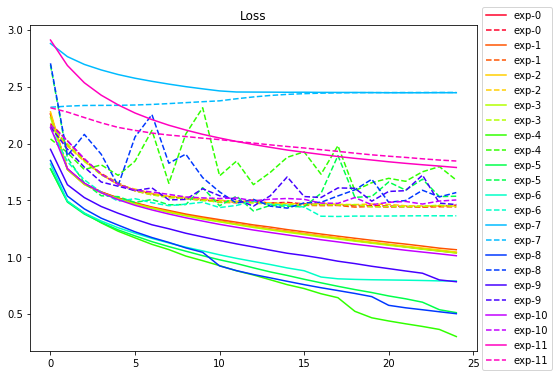

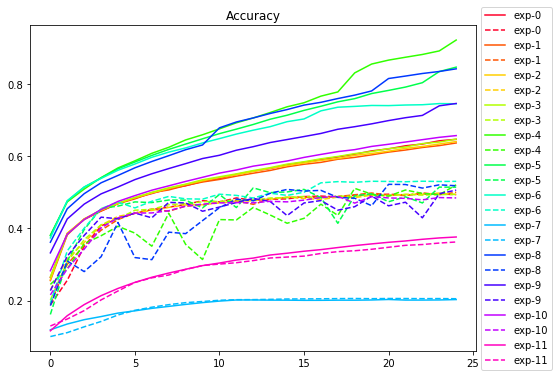

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()